In [1]:
#import libraries
import os
import sys
from osgeo import gdal,ogr,osr
import math
import numpy as np
import pandas as pd
from scipy import ndimage as ndi

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops,regionprops_table
#from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
#function to plot arrays
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

In [3]:
#function to convert arrays to geo rasters
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [4]:
#function to convert rasters to vectors
def raster2vector(raster_loc, shp_loc_name):
    src_ds = gdal.Open(raster_loc)
    srs = osr.SpatialReference()
    srs.ImportFromWkt(src_ds.GetProjection())
    srcband = src_ds.GetRasterBand(1)
    dst_layername = shp_loc_name
    drv = ogr.GetDriverByName("ESRI Shapefile")
    dst_ds = drv.CreateDataSource( dst_layername + ".shp" )
    dst_layer = dst_ds.CreateLayer(dst_layername, srs = srs)
    gdal.Polygonize( srcband, None, dst_layer, -1, [], callback=None )
    dst_ds = None
    src_ds = None

In [5]:
#input:canopy height model (CHM) file
workspace = r'\\bctsdata.bcgov\data\tko_root\GIS_WORKSPACE\MLABIADH\LIDAR\tree_volume\data\prod_only'
chm_file = os.path.join (workspace, 'prod_TA0075_4.tif')
file_name = os.path.basename(chm_file).split(".")[0]

In [6]:
#open CHM with gdal
chm_dataset = gdal.Open(chm_file)

#get band object
chm_raster = chm_dataset.GetRasterBand(1)

#get the NO DATA value
noDataVal_chm = chm_raster.GetNoDataValue()

#get required metadata from CHM file
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm =chm_dataset.GetGeoTransform()
xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]
pixelSizeX = mapinfo_chm[1]
pixelSizeY = - mapinfo_chm[5]

xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
image_extent = (xMin,xMax,yMin,yMax)

print ("CHM image size is {} px by {} px." . format (cols_chm,rows_chm))
print ("Pixel size is {} m." . format (pixelSizeX))

CHM image size is 435 px by 329 px.
Pixel size is 1.0 m.


In [7]:
#read the chm as array
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

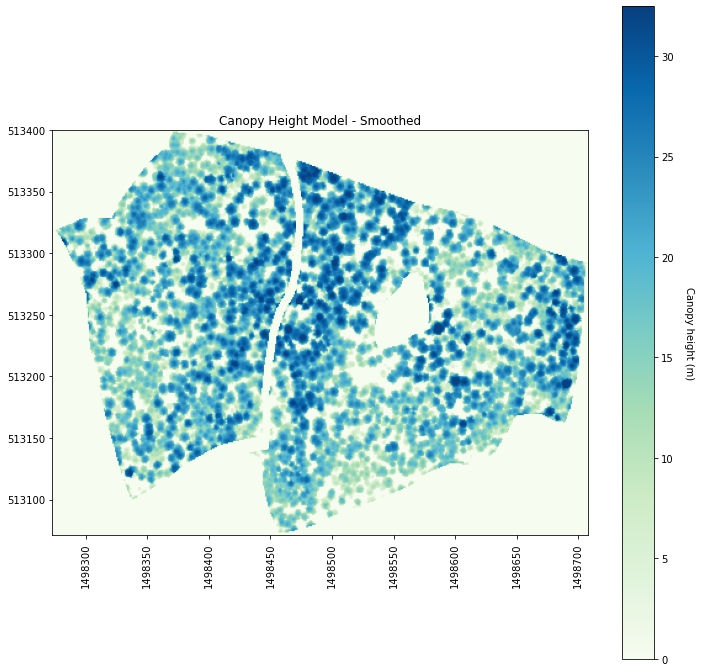

In [27]:
#Smooth the CHM using a gaussian filter to remove spurious points ****ADJUST FOR NEED***
# adjust the standard deviation for smoothing level
stDev = 0.5 
chm_array_smooth = ndi.gaussian_filter(chm_array,stDev,mode='constant',cval=0,truncate=1).astype(np.float)

#Cleanup the CHM. minimum tree height is considered ***ADJUST IF REQUIRED***
min_tree_height = 3
chm_array_smooth_filter = np.where(chm_array_smooth < min_tree_height, 0, chm_array_smooth)

#PLot the smoothed CHM
plt.figure(figsize=(12,12))
max_val = chm_array_smooth_filter.max()
plot_band_array(chm_array_smooth_filter,image_extent,
                'Canopy Height Model - Smoothed','Canopy height (m)','GnBu',[0, max_val-5])

In [28]:
# Export smoothed CHM raster ***OPTINAL***
#output_smoothed_chm = os.path.join (workspace, 'xx_chm_smoothed_minTree_' + file_name + '.tif')
#array2raster(output_smoothed_chm,(xMin,yMax),1,-1,chm_array_smooth_filter,26911)

In [29]:
# Function to create kernels.
def get_kernel(radius=3, circular=False):
    if circular:
        y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
        return x**2 + y**2 <= radius**2
    else:
        return np.ones((int(radius), int(radius)))

In [30]:
#Calculate local maximum points in the smoothed CHM
kernel = get_kernel(radius=3, circular=False)
local_maxi = peak_local_max(chm_array_smooth_filter,indices=False, footprint=kernel)

In [31]:
# Export a .csv with tree XY location ***OPTIONAL***
trees = np.array(np.where(local_maxi==1)).T

Xs = xMin + trees[:, 1] / mapinfo_chm[1]
ys = yMax + trees[:, 0] / mapinfo_chm[5]

df_coord = pd.DataFrame({'X':Xs, 'Y':ys})
#df_coord.to_csv(os.path.join (workspace, 'tree_loc_coords.csv'))

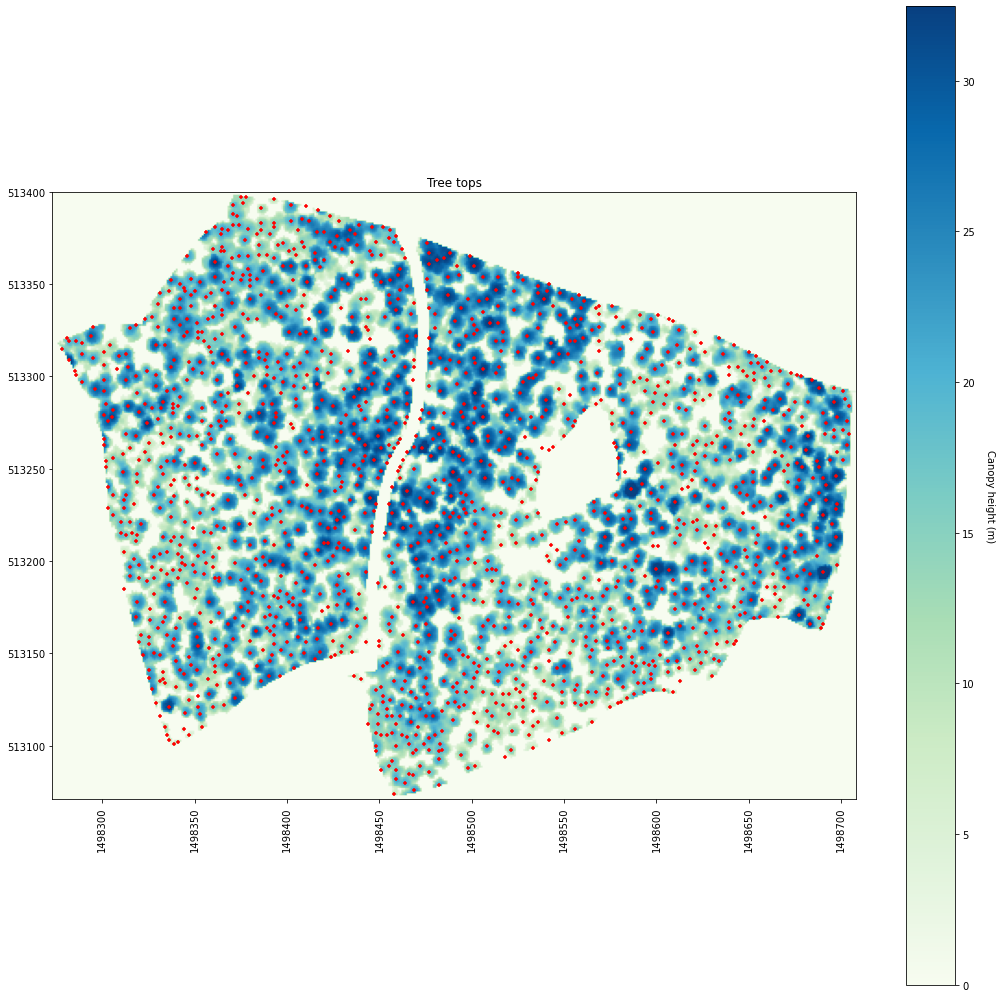

In [32]:
# Plot the tree tops
fig, ax= plt.subplots(figsize=(18,18))
plt.scatter(df_coord['X'], df_coord['Y'], marker="+", s = 10, c = "red")

max_val = chm_array_smooth_filter.max()
plot_band_array(chm_array_smooth_filter,image_extent,'Tree tops','Canopy height (m)','GnBu',[0, max_val-5])

plt.show()

In [33]:
#Identify all the maximum points (extract non-zero values)
markers = ndi.label(local_maxi)[0]

#Create a CHM mask so the segmentation will only occur on the trees
chm_mask = chm_array_smooth_filter
chm_mask[chm_mask != 0] = 1

#Perfrom watershed segmentation  
labels = watershed(chm_array_smooth_filter, markers, mask=chm_mask)

Locator attempting to generate 1734 ticks ([0.0, ..., 1733.0]), which exceeds Locator.MAXTICKS (1000).


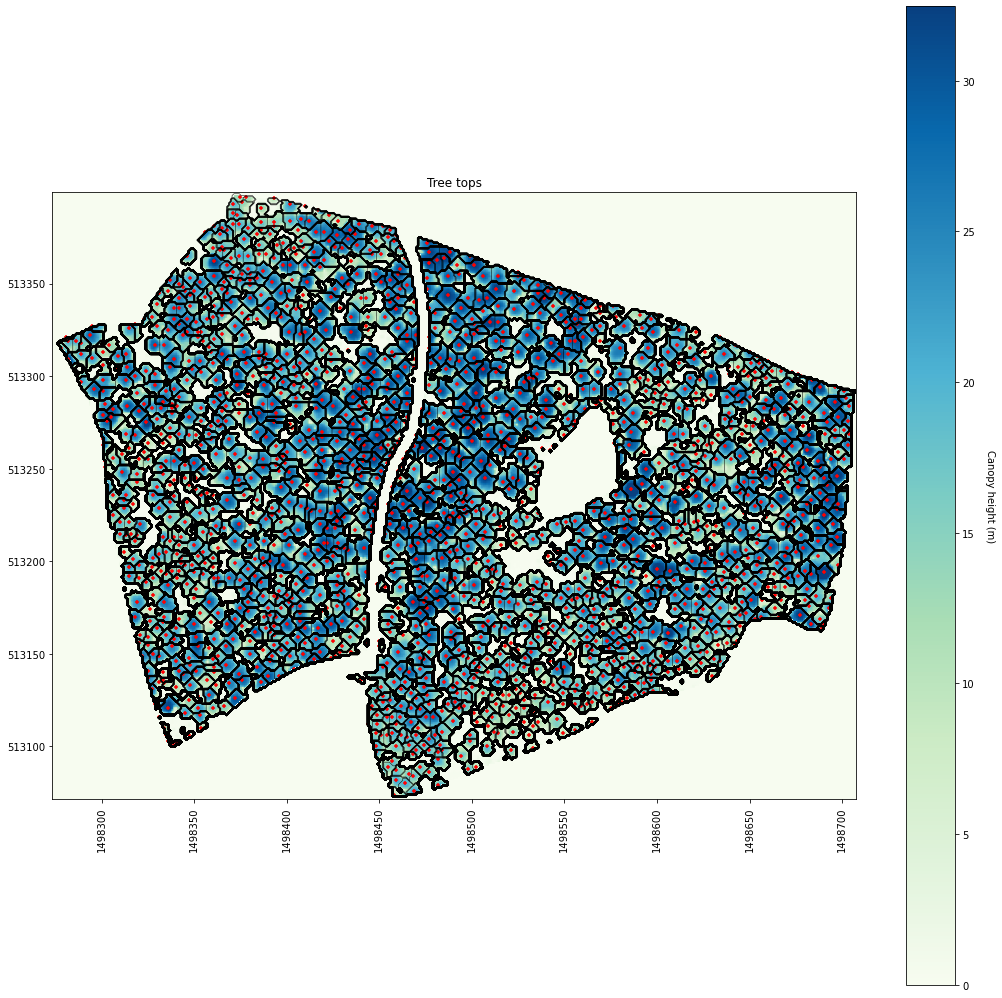

In [34]:
#Plot labels (tree crowns)
fig, ax = plt.subplots(figsize=(18,18))

plt.scatter(df_coord['X'], df_coord['Y'], marker="+", s = 10, c = "red")
plt.contour(labels, labels.max(), colors='black', linewidths = 0.5, origin = 'upper', extent = image_extent)
plot_band_array(chm_array_smooth,image_extent,'Tree crowns','Canopy height (m)','GnBu',[0, max_val-5])

plt.show()

In [35]:
# Export Tree loc and crown rasters ***OPTINAL***

#local maxima (tree tops)
#output_maxima = os.path.join (workspace, 'xx_maxima_tree_locations_minTree_' + file_name + '.tif')
#array2raster(output_maxima,(xMin,yMax),1,-1,local_maxi,3005)

#labels (crown segmentation) (tree crowns)
#output_labels = os.path.join (workspace, 'xx_crowns_minTree_' + file_name + '.tif')
#array2raster(output_labels,(xMin,yMax),1,-1,labels,26911)

In [36]:
#Get the properties of each segment (tree crown): area in nbr of pixels. min height and max height
tree_properties = regionprops_table(labels,chm_array_smooth, properties=('label', 'min_intensity',
                                                                  'max_intensity','area'))

In [37]:
# Convert properties to dataframe and 
df_prop = pd.DataFrame(tree_properties)


# Change column names
df_prop = df_prop.rename(columns={'label': 'tree_crown_id',
                                  'min_intensity': 'min_height', 
                                  'max_intensity': 'max_height',
                                  'area': 'tree_crown_pixels'})

#Add Tree XYs
df = df_coord.join(df_prop)

print ('Stem count: {}' .format(df.shape[0]))
df

Stem count: 1733


,X,Y,tree_crown_id,min_height,max_height,tree_crown_pixels
0,1498375.0,513397.0,1,12.052417,15.357449,18
1,1498378.0,513397.0,2,5.435459,14.392976,15
2,1498393.0,513396.0,3,4.125583,10.306043,15
3,1498376.0,513394.0,4,5.487791,16.262214,39
4,1498371.0,513393.0,5,8.456424,20.412786,26
...,...,...,...,...,...,...
1728,1498459.0,513082.0,1729,5.658469,21.981400,40
1729,1498464.0,513080.0,1730,3.220271,20.793509,37
1730,1498482.0,513079.0,1731,3.014136,21.701829,30
1731,1498469.0,513076.0,1732,3.347504,23.545884,31


In [42]:
# Calculate Crown Area
df['crown_area'] = df['tree_crown_pixels'] * pixelSizeX * pixelSizeY

# Calculate DBH.
# DBH Equations depends on dominant Tree Species
tree_species = "Aspen_Balsam"

# Set the Regression Coefficents for each species
if tree_species == "Aspen_Balsam" : 
    eq3_a = -3.782
    eq3_b = 0.979
    eq3_c = 0.893
    eq7_a = 0.621
    eq7_b = 0.418
    eq7_c = 0.209
    eq7_d = 0.414
    eq9_a = 0.471
    eq9_b = 0.029
    eq9_c = -0.025
    eq10_a = -0.0044
    eq10_b = 0.904
    eq10_c = 0.208
     
elif tree_species == "Lodgepole Pine" or tree_species == "Douglas fir":
    eq3_a = 13.593
    eq3_b = 0.085
    eq3_c = 0.998
    eq7_a = 12.782
    eq7_b = -0.139
    eq7_c = 0.099
    eq7_d = 2.897
    eq9_a = 1.543
    eq9_b = -0.025
    eq9_c = 0.040
    eq10_a = 1.260
    eq10_b = -0.086
    eq10_c = 0.247
    
elif tree_species == "White Spruce":
    eq3_a = -1.402
    eq3_b = 1.113
    eq3_c = 0.704
    eq7_a = -1.209
    eq7_b = 0.888
    eq7_c = 0.111
    eq7_d = 1.386
    eq9_a = 0.941
    eq9_b = 0.0165
    eq9_c = 0.070
    eq10_a = 0.165
    eq10_b = 0.802
    eq10_c = 0.238


    # DBH equations
df['DBH (eq3)'] = (eq3_a) + (eq3_b*df['max_height']) + \
                  (eq3_c*df['crown_area'])

df['DBH (eq7)'] = (eq7_a) + (eq7_b*df['max_height']) + \
                           (eq7_c*df['max_height']*pow(df['crown_area'],0.5)) + \
                           (eq7_d*pow(df['crown_area'],0.5)) 

#df['DBH (eq9)'] = (eq9_a*df['max_height']) + \
                  #(eq9_b*pow(df['max_height'],2)) + \
                  #(eq9_c*np.sin(df['max_height'])*df['max_height'])


df['DBH (eq10)'] = pow (10, (eq10_a) + (eq10_b*np.log10(df['max_height'])) + \
                            (eq10_c*np.log10(df['crown_area'])))


df['DBH (average)'] = df.iloc[:, 5:8].mean(axis=1)

df

,X,Y,tree_crown_id,min_height,max_height,tree_crown_pixels,crown_area,DBH (eq3),DBH (eq7),DBH (eq10),DBH (average)
0,1498375.0,513397.0,1,12.052417,15.357449,18,18.0,27.326943,22.414500,21.336793,21.108981
1,1498378.0,513397.0,2,5.435459,14.392976,15,15.0,23.703723,19.891124,19.372922,17.901241
2,1498393.0,513396.0,3,4.125583,10.306043,15,15.0,19.702617,14.874604,14.323928,16.567539
3,1498376.0,513394.0,4,5.487791,16.262214,39,39.0,46.965707,31.229550,26.390514,41.655236
4,1498371.0,513393.0,5,8.456424,20.412786,26,26.0,39.420118,33.018344,29.789699,30.473373
...,...,...,...,...,...,...,...,...,...,...,...
1728,1498459.0,513082.0,1729,5.658469,21.981400,40,40.0,53.457791,41.483311,34.837463,44.485930
1729,1498464.0,513080.0,1730,3.220271,20.793509,37,37.0,49.615846,38.265684,32.598130,41.205282
1730,1498482.0,513079.0,1731,3.014136,21.701829,30,30.0,44.254090,36.802891,32.436494,34.751363
1731,1498469.0,513076.0,1732,3.347504,23.545884,31,31.0,46.952421,40.167702,35.157209,36.317474


In [43]:
df['DBH (eq7)'].describe()

count    1733.000000
mean       45.340627
std        15.325160
min         2.937841
25%        34.755354
50%        44.996628
75%        56.227416
max        92.639115
Name: DBH (eq7), dtype: float64

In [44]:


df1 = pd.DataFrame(data={'col1': ['a', 'b'], 'col2': [1, 2]})
df2 = pd.DataFrame(data={'col1': ['c', 'd'], 'col2': [3, 4]})

df1.columns == df2.columns

array([ True,  True])

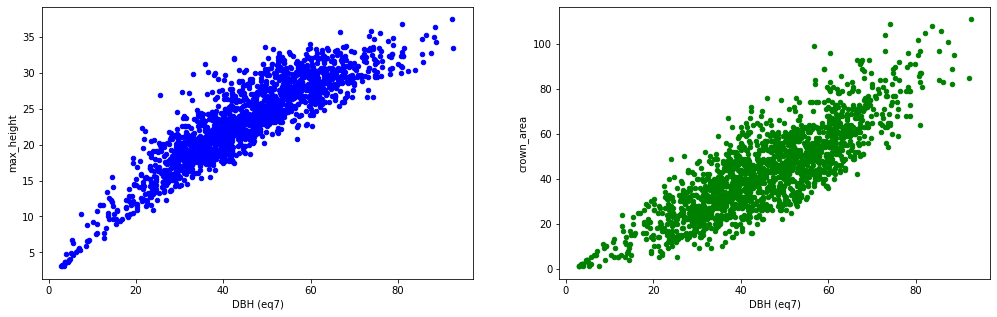

In [45]:
# Scatter plots of DBH vs Height and Crown Area
fig, axs = plt.subplots(1,2, figsize=(17, 5))
df.plot(kind='scatter',x='DBH (eq7)',y='max_height',color='blue', ax=axs[0]) 
df.plot(kind='scatter',x='DBH (eq7)',y='crown_area',color='green', ax=axs[1])
plt.show()

In [46]:
# Calculate Volume.
# Set the Regression Coefficents for each species

if  tree_species == "White Spruce":
    a = -4.294193
    b = 1.85859
    c = 1.00779
elif tree_species == "Aspen_Balsam":
    a = -4.291919 
    b = 1.872930
    c = 0.998274   
elif tree_species == "Douglas fir":
    a = -4.383102
    b = 1.742940
    c = 1.156410
elif tree_species == "Lodgepole Pine":  
    a = -4.349504
    b = 1.822760
    c = 1.108120
    
    
# Stem Volume equation (BC Forests 1976)

df['Volume (m3)'] = pow(10,(a) + \
                           (b*np.log10(df['DBH (eq7)'])) + \
                           (c*np.log10(df['max_height']))) 

df

,X,Y,tree_crown_id,min_height,max_height,tree_crown_pixels,crown_area,DBH (eq3),DBH (eq7),DBH (eq10),DBH (average),Volume (m3)
0,1498375.0,513397.0,1,12.052417,15.357449,18,18.0,27.326943,22.414500,21.336793,21.108981,0.264119
1,1498378.0,513397.0,2,5.435459,14.392976,15,15.0,23.703723,19.891124,19.372922,17.901241,0.197939
2,1498393.0,513396.0,3,4.125583,10.306043,15,15.0,19.702617,14.874604,14.323928,16.567539,0.082287
3,1498376.0,513394.0,4,5.487791,16.262214,39,39.0,46.965707,31.229550,26.390514,41.655236,0.520460
4,1498371.0,513393.0,5,8.456424,20.412786,26,26.0,39.420118,33.018344,29.789699,30.473373,0.724844
...,...,...,...,...,...,...,...,...,...,...,...,...
1728,1498459.0,513082.0,1729,5.658469,21.981400,40,40.0,53.457791,41.483311,34.837463,44.485930,1.196695
1729,1498464.0,513080.0,1730,3.220271,20.793509,37,37.0,49.615846,38.265684,32.598130,41.205282,0.973252
1730,1498482.0,513079.0,1731,3.014136,21.701829,30,30.0,44.254090,36.802891,32.436494,34.751363,0.944187
1731,1498469.0,513076.0,1732,3.347504,23.545884,31,31.0,46.952421,40.167702,35.157209,36.317474,1.206639


In [47]:
print ("Timber volume in AOI is {} m3." .format (int (df['Volume (m3)'].sum())))

Timber volume in AOI is 3209 m3.


In [25]:
#Export results to csv
#results = os.path.join (workspace, 'result_stats.csv')
#df.to_csv (results)